# Using NLP to Detect Sarcasm in News Headlines

## Project Description:

**Natural Language Processing** (or NLP) can be used to analyze or generate texts. This can be useful for many reasons, like creating a chatbot to automate answers to customers questions, or perform sentiment analysis on clients reviews.  
Today we will build a simple neural network to perfom classification, in order to detect sarcasm in news headlines. The aim of the project was to discover NLP by practice, already having some kind of knowledge in Neural Networks.    
This project is using a dataset found on Kaggle, as usual: "News Headlines Dataset For Sarcasm Detection".  

For this project we will follow multiple steps :

- First import the necessary librairies
- Load and explore the dataset
- Preprocess the data
- Represent the text data with Word2Vec 
- Build a Neural Network model
- Test the model

The dataset we will use is, as usual, from Kaggle. Many people have tried to perform similar projects on this dataset, so I hope it works fine!

## Importing the libraries:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gensim
import random
import re

from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence

import nltk
from nltk.corpus import stopwords

from scipy.stats import norm
from scipy.optimize import curve_fit

## Loading and exploring the dataset:

Let's load our dataset that we downloaded in "json" format on Kaggle. We can load it directly in a dataframe by using the **pd.read_json()** function. A good reflex is to take a first look at our dataset to see what it looks like ; we can do that with the **head()** function, to return the first rows (5 by default) of the dataframe.

In [2]:
path="./datasets/Sarcasm_Headlines_Dataset_v2.json"
data = pd.read_json(path,lines=True)
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


We don't need the link to the article in our dataframe, so we will get rid of this column by using the **drop()** function.

In [3]:
data.drop(columns="article_link", axis=1,inplace=True)
data.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


To have a clearer overview of our data, we can ask for the "infos" of the dataset. In particular, we can see the number of non-null values that we have in the dataset, to make sure that we do not have missing values. Of course, the purpose of this project is to learn teh basics of NLP with an example, so picked a small and simple dataset without any missing values. Here's what it looks like:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
dtypes: int64(1), object(1)
memory usage: 447.3+ KB


We checked fo missing values, but it's also important to check form duplicates in the dataset, especially to avoid overfitting on the traing set when training.

In [5]:
data = data.drop_duplicates(subset = 'headline')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28503 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28503 non-null  int64 
 1   headline      28503 non-null  object
dtypes: int64(1), object(1)
memory usage: 668.0+ KB


## Visualization of the dataset:

In this project we are working on a classification problem, more specificallt a binary classification problem, as we only have 2 classes: 

- Sarcastic (1)
- Not Sarcastic (0)

It is good practice to check if the dataset is balanced: we can use a pie chart to take a quick look at the distribution.

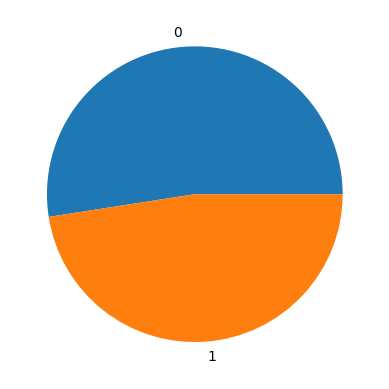

In [6]:
s=data["is_sarcastic"].value_counts()
plt.pie(s,labels=s.index)
plt.show()

Comments on the chart:<br>
As we can see, the dataset is quite balanced (which is always good to have when working on a dataset). In total we have around 14,000 "headlines" per category.  

The next thing that I wanted to check is is the distribution of headline lengths: how long are the headlines in our dataset? Are the sarcastic headlines longer than the normal headlines? Those questions can help us get a first clue on the possible differences that occur between the 2 types of headlines.    
First, we need to get the length of each headline, which can be done in different ways: counting the words or counting the characters in a sentence. We chose to count the number of characters, as having many words does not always mean that we have a "long" headline. Also, it is clear that there are many more characters than words in a sentence, so the distribution will be more precise. If you are curious, I also tried the other method, which gives similar results on the distribution curve :)
We then need to count the number of headlines for each length: we can use the **value_counts()** function on pandas Series.

In [7]:
data["length"] = data["headline"].str.len()
count_length = data["length"].value_counts()

We than plot the number of headlines for each possible length of text, using a histogram. Important to note: the number of bins in the histogram is determined by the range of values for the lengths, by taking the min and max values.

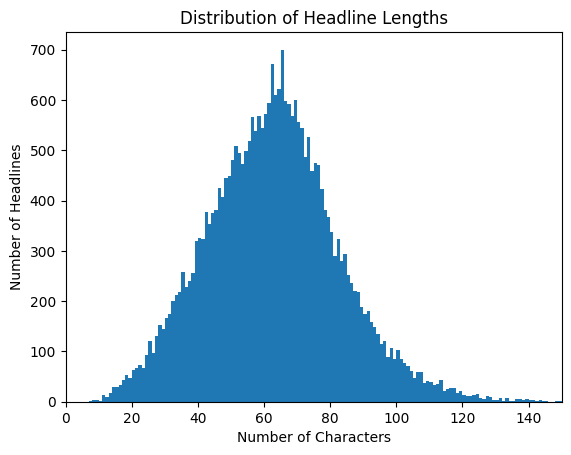

In [8]:
plt.hist(data['length'], bins=range(min(data['length']), max(data['length']) + 1))
plt.xlabel('Number of Characters')
plt.ylabel('Number of Headlines')
plt.title('Distribution of Headline Lengths')
plt.xlim(0, 150)
plt.show()

Comments on the distribution of lengths: <br>
as we could have expected, we have something that looks very much like a normal distribution. Tha average number of characters in a news headline is around 65, and a common length value varies between 20 and 120.
To prove the similrity to a gaussian curve (and because it's fun), we can fit a gaussian on our distribution and compute the parameters that define the gaussian distribution. The most important step to understand is that we use the **norm.fit()** function from scipy.stats that we have imported.

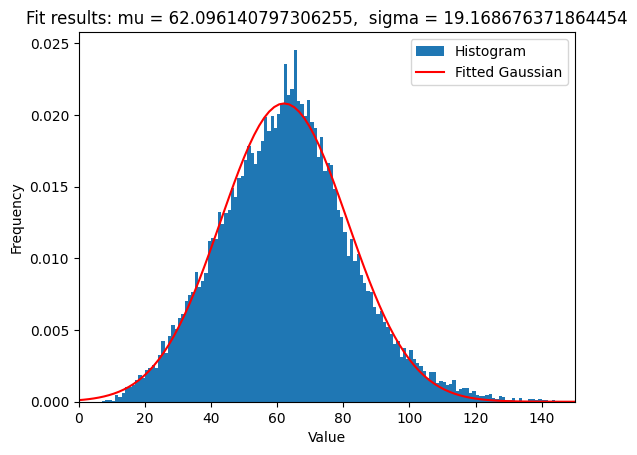

In [9]:
hist, bin_edges, _ = plt.hist(data["length"], bins=range(min(data['length']), max(data['length']) + 1), density=True, label='Histogram')

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

mu, sigma = norm.fit(data["length"])
def gaussian(x, mu, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma)**2)

params, covariance = curve_fit(gaussian, bin_centers, hist, p0=[mu, sigma])

plt.xlim(0, 150)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
plt.plot(x, gaussian(x, *params), 'r', label='Fitted Gaussian')


plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title(f'Fit results: mu = {params[0]},  sigma = {params[1]}')
plt.legend()

plt.show()

Comments on the plot: <br>
As expected, we are dealijng with a normal distribution, confirmed by the fitted Gaussian (in red). The parameters of the fitted Gaussian are the following: mean of 62 and a standart deviation of around 20. <br><br> <br><br>
Now we want to divide the dataset in two: the sarcastic and the non-sarcastic headlines. The aim behind this is that we want to see if the distribution of lengths is different for the two types of headline. It is quite simple to divide the dataframe in to dataframes, **sarcastic** and **not_sarcastic**. We then use to same histogram plot as before on the new dataframes.

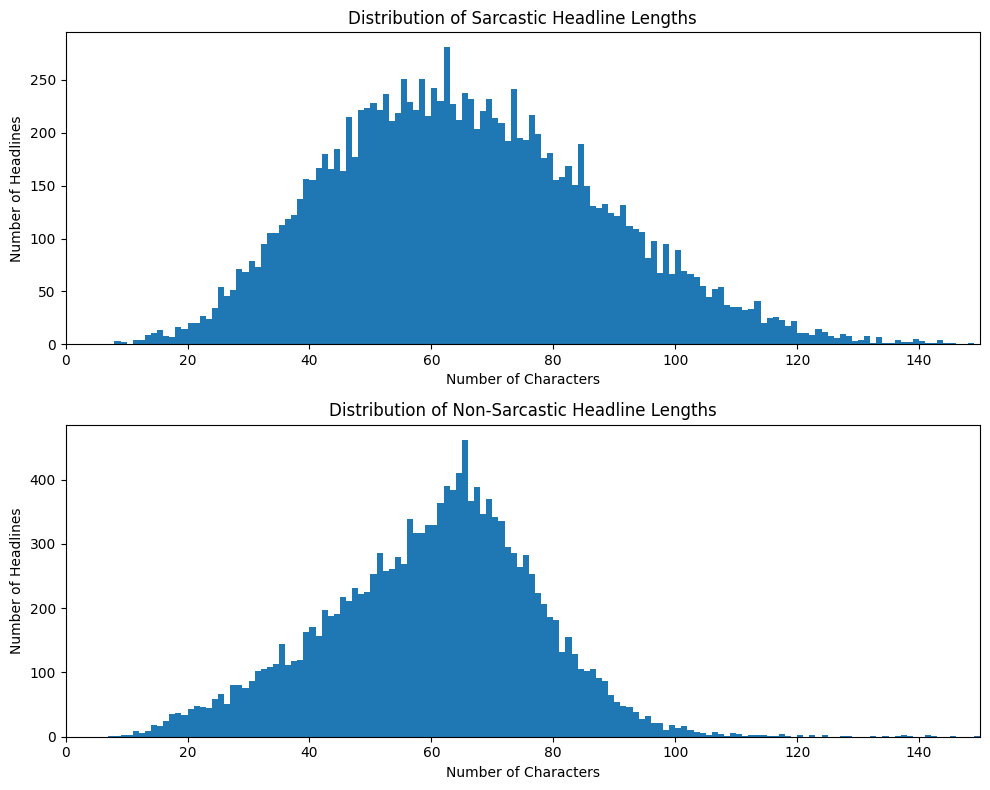

In [10]:
sarcastic = data[data["is_sarcastic"]==1]
not_sarcastic = data[data["is_sarcastic"]==0]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.hist(sarcastic['length'], bins=range(min(sarcastic['length']), max(sarcastic['length']) + 1))
ax1.set_xlabel('Number of Characters')
ax1.set_ylabel('Number of Headlines')
ax1.set_title('Distribution of Sarcastic Headline Lengths')
ax1.set_xlim(0, 150)

ax2.hist(not_sarcastic['length'], bins=range(min(not_sarcastic['length']), max(not_sarcastic['length']) + 1))
ax2.set_xlabel('Number of Characters')
ax2.set_ylabel('Number of Headlines')
ax2.set_title('Distribution of Non-Sarcastic Headline Lengths')
ax2.set_xlim(0, 150)

plt.tight_layout()
plt.show()

Comments on the plots: <br>
Let's first remember that the dataset is balanced, so we have an equal amount of headlines in each category.<br>
It seems like the average number of characters is the same for both classes, slightly above 60. The main difference is the range of values observed: for the sarcastic headlines, the lengths are more evenly distributed and we can see more headlines with lengths superior to 100. Those differences are interesting but are not enough to determine a criteria for classification. If we fall in the range between 20 and 100, it is not possible to make any prediction.

## Preprocessing:

Now it's time to do some preprocessing on the corpus of text that we have. The corpus of text is just the addition of all the different headlines in our dataset. The preprocessing on our entire text basically consists of cleaning the text: we will remove all of the punctuation and the stopwords (words that do not bring any meaning to the sentence, like common verbs of linking words). We could build our own list of stop words but we will simply download a made up list form the famous **nltk** library (we downloaded the ditionnary in the imports section).

In [11]:
stop_words = list(set(stopwords.words('english')))

We will now create the different functions to clean our text: one function for removing the punctuation and one for removing the stop words.

In [12]:
def remove_punctuation(text):
    punctuation = r'[!\"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]'
    return re.sub(punctuation, '', text)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = re.findall(r'\b\w+\b', text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def clean_text(text):
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    return text

clean_words_list = [clean_text(i) for i in data["headline"].values]

print(clean_words_list[0])

thirtysomething scientists unveil doomsday clock hair loss


Comment on the output: <br>
In the first headline of our dataset, we can see that the stop word "of" was removed.<br><br>
The final step is to create a list named **words** containing all the cleaned headlines.

In [13]:
words = []
for i in clean_words_list:
    words.append(i.split())
words[0]

['thirtysomething',
 'scientists',
 'unveil',
 'doomsday',
 'clock',
 'hair',
 'loss']

## Word Embedding with Word2Vec :

We will first initialize a model using gensim and more precisely the Word2Vec model. 

In [14]:
emb_dim = 200

w2v_model = gensim.models.Word2Vec(sentences = words , vector_size=emb_dim , window = 4 , min_count = 1)

We also use a Tokenizer (from the keras library) to divide the sentences into words and apply some padding, so that each vector has the same length.

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)

x = sequence.pad_sequences(tokenized_train, maxlen = 25) #Goes in the NN 
y = data["is_sarcastic"]

The follwoing step is an important one: we cerate a function to compute the weight matrix, which will be used in our future Neural Network. Next, we need to apply the function to our model and vocabulary.

In [16]:
def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, emb_dim))
    for word, i in vocab.items():
        try :
            weight_matrix[i] = model[word]
        except KeyError:
            pass
    return weight_matrix

In [17]:
embedding_matrix = get_weight_matrix(w2v_model.wv, tokenizer.word_index)
print(embedding_matrix.shape)

(26225, 200)


The dimensions of our weight matrix correspond to the number of words in our dictionnary of vocabulary (26225) and the embedding dimension (200), which is the dimension of the word vectors.

## Building the NN and training:

It is now time to build our Neural Network that make the predictions on the label for each headline. We will build a sequential model by adding different layers. We can quickly describe each of the layer that we will use in our neural network:

- Embedding Layer: it is responsible for converting integer-encoded words into dense vectors of fixed size.
- Bidirectional LSTM Layer: a type of RNN layer that processes the input data in the forward and also in the backward directions.
- Bidirectional GRU Layer: quite similar to the Bidirectional LSTM Layer, but using other type of units (the concept stays the same).
- Dense Output Layer: single neuron output, very common for binary classification problems.

Let's assemble all those layers together:

In [18]:
vocab_size = len(tokenizer.word_index) + 1

model = Sequential()

model.add(Embedding(vocab_size, output_dim=emb_dim, weights=[embedding_matrix], input_length=25, trainable=True))

model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.5 , dropout = 0.5,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.3 , dropout = 0.3)))
model.add(keras.layers.BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['acc'])

We're almost ready for the training: we just need to split our dataset in a training set and a test set. We do that by using the **train_test_split** function from scikitlearn.

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2) 

Out of principle we first evaluate the untrained model on th test set, in order to check that the model runs smoothly and that we have a random classifier. After that we start the training of the model, with a small amount of epochs.

In [20]:
eval = model.evaluate(x_test,y_test)

179/179 [==============================] - 5s 24ms/step - loss: 0.6936 - acc: 0.5183


In [21]:
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 3)

Epoch 1/3
179/179 [==============================] - 63s 326ms/step - loss: 0.5201 - acc: 0.7342 - val_loss: 0.4404 - val_acc: 0.8041
Epoch 2/3
179/179 [==============================] - 69s 385ms/step - loss: 0.2213 - acc: 0.9125 - val_loss: 0.5691 - val_acc: 0.7865
Epoch 3/3
179/179 [==============================] - 70s 389ms/step - loss: 0.0901 - acc: 0.9681 - val_loss: 0.7015 - val_acc: 0.7978


We finish everything by plotting the results :

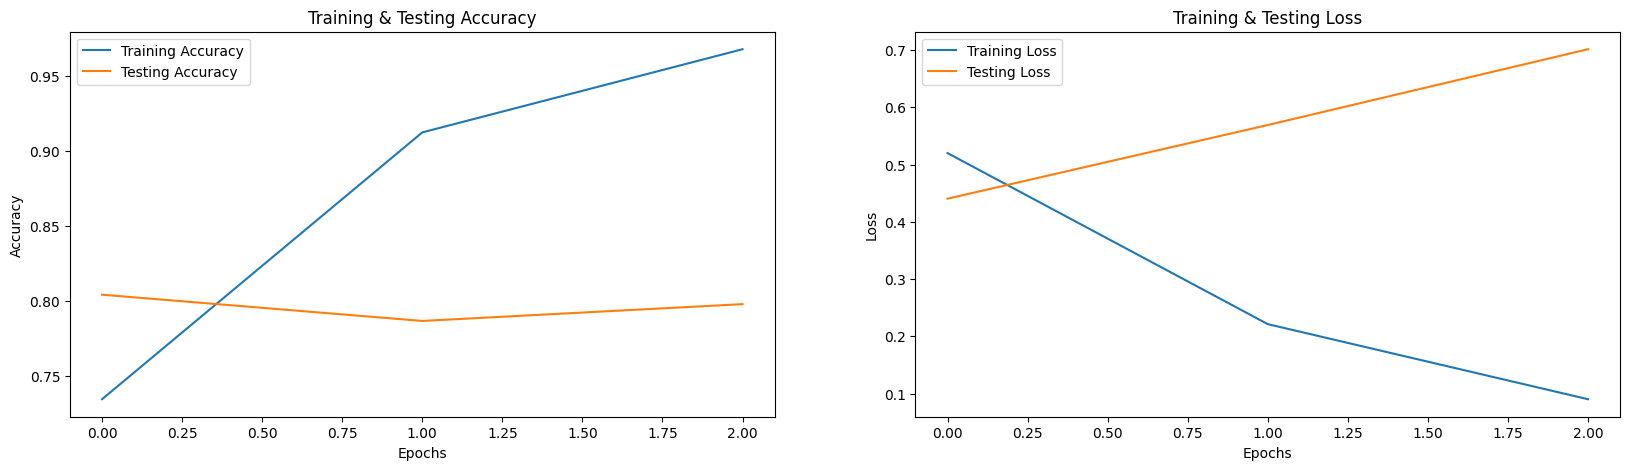

In [22]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,5)

ax[0].plot(epochs , train_acc , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc, label = 'Testing Accuracy')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()

ax[1].plot(epochs , train_loss, label = 'Training Loss')
ax[1].plot(epochs , val_loss, label = 'Testing Loss')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
plt.show()

Comments on the results: <br>
For the training, we can see that the model is able to learn from the data quite nicely: the training accuracy seems to be converging towards 1 and the training loss decreases as the model is learning. But the problem is the gap between the accuracy on the training set and on the test set. Our model seems to be overfitting quite a lot. At the end we obtain an accuracy on the test set of around 80%, which is not terrible (it is much better than guessing randomly), but could definitvely be improved. Also it is not quite satisfying that the testing accuracy somehow decreases and rises again (to be fully honest I do not know why that is the case).